In [1]:
import mitiq

mitiq.SUPPORTED_PROGRAM_TYPES.keys()

dict_keys(['cirq', 'pyquil', 'qiskit', 'braket', 'pennylane'])

In [2]:
from cirq import LineQubit, Circuit, X, measure_each

from mitiq.observable.observable import Observable
from mitiq.observable.pauli import PauliString

qreg = [LineQubit(i) for i in range(2)]
circuit = Circuit(X.on_each(*qreg))
observable = Observable(PauliString("ZI"), PauliString("IZ"))

print(circuit)

0: ───X───

1: ───X───


In [4]:
pip install pytest

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Srushti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [5]:
from functools import partial

import numpy as np
from cirq.experiments.single_qubit_readout_calibration_test import (
    NoisySingleQubitReadoutSampler,
)

from mitiq import MeasurementResult

def noisy_readout_executor(circuit, p0, p1, shots=8192) -> MeasurementResult:
    # Replace with code based on your frontend and backend.
    simulator = NoisySingleQubitReadoutSampler(p0, p1)
    result = simulator.run(circuit, repetitions=shots)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings, qubit_indices = (0, 1))

In [6]:
from mitiq.raw import execute as raw_execute

# Compute the expectation value of the observable.
# Use a noisy executor that has a 25% chance of bit flipping
p_flip = 0.25
noisy_executor = partial(noisy_readout_executor, p0=p_flip, p1=p_flip)
noisy_value = raw_execute(circuit, noisy_executor, observable)

ideal_executor = partial(noisy_readout_executor, p0=0, p1=0)
ideal_value = raw_execute(circuit, ideal_executor, observable)
error = abs((ideal_value - noisy_value)/ideal_value)
print(f"Error without mitigation: {error:.3}")

Error without mitigation: 0.505


In [160]:
import matplotlib.pyplot as plt
import numpy as np

import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors.standard_errors import (
    depolarizing_error,
)

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory, PolyFactory, ExpFactory, AdaExpFactory, AdaptiveFactory, LinearFactory

In [96]:
phi1=Parameter('phi1')
#phi2 = Parameter('phi2')

def Hartree_Fock(qc):
    qc.x(0)
    qc.x(1)
    qc.x(4)
    qc.x(5)
    return qc

def first_excitation_circ(qc,i,k,theta):
    qc.cx(k,i)
    # controlled ry
    qc.ry(theta, k)
    qc.cx(i,k)
    qc.ry(-theta, k)
    qc.cx(i,k)

    qc.cx(k,i)

    return qc

def double_excitation_circ(qc,i,j,k,l,theta):
    qc.cx(l,k)
    qc.cx(j,i)
    qc.cx(l,j)
    # 3 controlled ry
    qc.ry(theta/4, l)
    qc.cx(k,l,ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(i,l, ctrl_state='0')
    qc.ry(theta/4, l)
    qc.cx(k,l, ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(j,l)
    qc.ry(theta/4, l)
    qc.cx(k,l, ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(i,l, ctrl_state='0')
    qc.ry(theta/4, l)
    qc.cx(k,l, ctrl_state='0')
    qc.ry(-theta/4, l)
    qc.cx(j,l)

    qc.cx(l,j)
    qc.cx(j,i)
    qc.cx(l,k)

    return qc

#list_T2 =[((1, 5), (2, 6)),((0,6),(3,7))]
list_T2=[((4, 5), (6, 7)), ((0, 5), (2, 7)), ((0, 1), (2, 3)), ((1, 4), (3, 6)), ((1, 5), (2, 6)), ((1, 5), (3, 7)), ((0, 4), (2, 6)), ((0, 4), (3, 7)), ((0, 5), (3, 6)), ((1, 4), (2, 5)), ((1, 6), (2, 7)), ((1, 4), (2, 7)), ((5, 0), (6, 1)), ((5, 2), (6, 3))]

list_T1=[((0,), (2,)), ((1,), (3,)), ((4,), (6,)), ((5,), (7,))]

def create_ansatz(double_exit: list, paramaters: list, single_exit: list):

    num_qubits = 8
    qc = QuantumCircuit(num_qubits)
    Hartree_Fock(qc)
    for n in range(len(list_T2)):
        double_excitation_circ(qc, double_exit[n][0][0], double_exit[n][0][1], double_exit[n][1][0], double_exit[n][1][1], paramaters[n])
    for m in range(len(single_exit)):
        first_excitation_circ(qc, single_exit[m][0], single_exit[m][1], paramaters[m+len(list_T2)])
    return qc

In [17]:
list_mitigated_result = []
nuclear_repulsion_energy = 0.76436708244
qubit_op = SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIIZZ', 'IIIIYZYI', 'IIIIYZYZ', 'IIIIXZXI', 'IIIIXZXZ', 'IIIIIZII', 'IIIIIZIZ', 'IIIIZIII', 'IIIIZIIZ', 'IIIZIIII', 'IIIZIIIZ', 'IYZYIIII', 'IYZYIIIZ', 'IXZXIIII', 'IXZXIIIZ', 'IIZIIIII', 'IIZIIIIZ', 'YZYIIIII', 'YZYIIIIZ', 'XZXIIIII', 'XZXIIIIZ', 'IZIIIIII', 'IZIIIIIZ', 'ZIIIIIII', 'ZIIIIIIZ', 'IIIIIYZY', 'IIIIIYIY', 'IIIIIXZX', 'IIIIIXIX', 'IIIIYYYY', 'IIIIXXYY', 'IIIIYXXY', 'IIIIXYYX', 'IIIIYYXX', 'IIIIXXXX', 'IIYYIIYY', 'IIXXIIYY', 'IIYYIIXX', 'IIXXIIXX', 'YZZYIIYY', 'XZZXIIYY', 'YZZYIIXX', 'XZZXIIXX', 'IYYIIIYY', 'IXXIIIYY', 'IYYIIIXX', 'IXXIIIXX', 'YYIIIIYY', 'XXIIIIYY', 'YYIIIIXX', 'XXIIIIXX', 'IIIIZYZY', 'IIIIZXZX', 'IIIZIYZY', 'IIIZIXZX', 'IYZYIYZY', 'IXZXIYZY', 'IYZYIXZX', 'IXZXIXZX', 'IIZIIYZY', 'IIZIIXZX', 'YZYIIYZY', 'XZXIIYZY', 'YZYIIXZX', 'XZXIIXZX', 'IZIIIYZY', 'IZIIIXZX', 'ZIIIIYZY', 'ZIIIIXZX', 'IIYYYZZY', 'IIXXYZZY', 'IIYYXZZX', 'IIXXXZZX', 'YZZYYZZY', 'XZZXYZZY', 'YZZYXZZX', 'XZZXXZZX', 'IYYIYZZY', 'IXXIYZZY', 'IYYIXZZX', 'IXXIXZZX', 'YYIIYZZY', 'XXIIYZZY', 'YYIIXZZX', 'XXIIXZZX', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IYZYIIZI', 'IXZXIIZI', 'IIZIIIZI', 'YZYIIIZI', 'XZXIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIYIYI', 'IIIIXIXI', 'IIYYIYYI', 'IIXXIYYI', 'IIYYIXXI', 'IIXXIXXI', 'YZZYIYYI', 'XZZXIYYI', 'YZZYIXXI', 'XZZXIXXI', 'IYYIIYYI', 'IXXIIYYI', 'IYYIIXXI', 'IXXIIXXI', 'YYIIIYYI', 'XXIIIYYI', 'YYIIIXXI', 'XXIIIXXI', 'IIIZYZYI', 'IIIZXZXI', 'IYZYYZYI', 'IXZXYZYI', 'IYZYXZXI', 'IXZXXZXI', 'IIZIYZYI', 'IIZIXZXI', 'YZYIYZYI', 'XZXIYZYI', 'YZYIXZXI', 'XZXIXZXI', 'IZIIYZYI', 'IZIIXZXI', 'ZIIIYZYI', 'ZIIIXZXI', 'IIIIZZII', 'IIIZIZII', 'IYZYIZII', 'IXZXIZII', 'IIZIIZII', 'YZYIIZII', 'XZXIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIYYYYII', 'IIXXYYII', 'IIYYXXII', 'IIXXXXII', 'YZZYYYII', 'XZZXYYII', 'YZZYXXII', 'XZZXXXII', 'IYYIYYII', 'IXXIYYII', 'IYYIXXII', 'IXXIXXII', 'YYIIYYII', 'XXIIYYII', 'YYIIXXII', 'XXIIXXII', 'IIIZZIII', 'IYZYZIII', 'IXZXZIII', 'IIZIZIII', 'YZYIZIII', 'XZXIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'YZYZIIII', 'XZXZIIII', 'IZIZIIII', 'ZIIZIIII', 'IYIYIIII', 'IXIXIIII', 'YYYYIIII', 'XXYYIIII', 'YXXYIIII', 'XYYXIIII', 'YYXXIIII', 'XXXXIIII', 'ZYZYIIII', 'ZXZXIIII', 'IZZIIIII', 'ZIZIIIII', 'YIYIIIII', 'XIXIIIII', 'ZZIIIIII'],
              coeffs=[-1.85502904e+00+0.j,  4.81583054e-02+0.j,  4.27360355e-02+0.j,
  2.57891581e-02+0.j,  2.04558562e-03+0.j, -6.27464680e-03+0.j,
  2.04558562e-03+0.j, -6.27464680e-03+0.j,  3.64529858e-02+0.j,
  3.30007159e-02+0.j,  3.06300748e-02+0.j,  3.86135390e-02+0.j,
  4.81583054e-02+0.j,  7.31661755e-02+0.j,  1.97123182e-03+0.j,
  8.76339225e-03+0.j,  1.97123182e-03+0.j,  8.76339225e-03+0.j,
  4.27360355e-02+0.j,  7.10045261e-02+0.j,  2.04558562e-03+0.j,
 -9.00548050e-03+0.j,  2.04558562e-03+0.j, -9.00548050e-03+0.j,
  3.64529858e-02+0.j,  7.12657357e-02+0.j,  3.06300748e-02+0.j,
  7.40674025e-02+0.j,  1.97123182e-03+0.j,  8.23208993e-03+0.j,
  1.97123182e-03+0.j,  8.23208993e-03+0.j, -1.10132664e-02+0.j,
 -7.20326168e-03+0.j, -3.81000468e-03+0.j, -3.81000468e-03+0.j,
 -7.20326168e-03+0.j, -1.10132664e-02+0.j,  4.52153680e-02+0.j,
  4.52153680e-02+0.j,  4.52153680e-02+0.j,  4.52153680e-02+0.j,
  2.73083370e-03+0.j,  2.73083370e-03+0.j,  2.73083370e-03+0.j,
  2.73083370e-03+0.j,  9.92105488e-03+0.j,  9.92105488e-03+0.j,
  9.92105488e-03+0.j,  9.92105488e-03+0.j, -4.56970944e-02+0.j,
 -4.56970944e-02+0.j, -4.56970944e-02+0.j, -4.56970944e-02+0.j,
  6.26587905e-03+0.j,  6.26587905e-03+0.j,  8.76339225e-03+0.j,
  8.76339225e-03+0.j,  3.82650198e-02+0.j,  3.82650198e-02+0.j,
  3.82650198e-02+0.j,  3.82650198e-02+0.j, -1.68896495e-03+0.j,
 -1.68896495e-03+0.j, -3.84938327e-02+0.j, -3.84938327e-02+0.j,
 -3.84938327e-02+0.j, -3.84938327e-02+0.j, -1.91756644e-03+0.j,
 -1.91756644e-03+0.j,  8.98699815e-03+0.j,  8.98699815e-03+0.j,
  2.73083370e-03+0.j,  2.73083370e-03+0.j,  2.73083370e-03+0.j,
  2.73083370e-03+0.j,  3.54538635e-02+0.j,  3.54538635e-02+0.j,
  3.54538635e-02+0.j,  3.54538635e-02+0.j, -3.46838280e-02+0.j,
 -3.46838280e-02+0.j, -3.46838280e-02+0.j, -3.46838280e-02+0.j,
 -2.72111910e-03+0.j, -2.72111910e-03+0.j, -2.72111910e-03+0.j,
 -2.72111910e-03+0.j,  3.45690108e-02+0.j,  3.31222731e-02+0.j,
  7.10045261e-02+0.j, -1.68896495e-03+0.j, -1.68896495e-03+0.j,
  7.17102376e-02+0.j,  1.49535906e-03+0.j,  1.49535906e-03+0.j,
  7.20235096e-02+0.j,  7.18631896e-02+0.j, -8.32688202e-03+0.j,
 -8.32688202e-03+0.j,  9.92105488e-03+0.j,  9.92105488e-03+0.j,
  9.92105488e-03+0.j,  9.92105488e-03+0.j, -3.46838280e-02+0.j,
 -3.46838280e-02+0.j, -3.46838280e-02+0.j, -3.46838280e-02+0.j,
  3.74544987e-02+0.j,  3.74544987e-02+0.j,  3.74544987e-02+0.j,
  3.74544987e-02+0.j, -1.00696391e-02+0.j, -1.00696391e-02+0.j,
 -1.00696391e-02+0.j, -1.00696391e-02+0.j, -9.00548050e-03+0.j,
 -9.00548050e-03+0.j, -3.84938327e-02+0.j, -3.84938327e-02+0.j,
 -3.84938327e-02+0.j, -3.84938327e-02+0.j,  1.49535906e-03+0.j,
  1.49535906e-03+0.j,  3.87409165e-02+0.j,  3.87409165e-02+0.j,
  3.87409165e-02+0.j,  3.87409165e-02+0.j,  1.74275708e-03+0.j,
  1.74275708e-03+0.j, -9.24626051e-03+0.j, -9.24626051e-03+0.j,
  2.59279774e-02+0.j,  7.12657357e-02+0.j, -1.91756644e-03+0.j,
 -1.91756644e-03+0.j,  7.20235096e-02+0.j,  1.74275708e-03+0.j,
  1.74275708e-03+0.j,  7.23838652e-02+0.j,  7.21433666e-02+0.j,
 -4.56970944e-02+0.j, -4.56970944e-02+0.j, -4.56970944e-02+0.j,
 -4.56970944e-02+0.j, -2.72111910e-03+0.j, -2.72111910e-03+0.j,
 -2.72111910e-03+0.j, -2.72111910e-03+0.j, -1.00696391e-02+0.j,
 -1.00696391e-02+0.j, -1.00696391e-02+0.j, -1.00696391e-02+0.j,
  4.62153892e-02+0.j,  4.62153892e-02+0.j,  4.62153892e-02+0.j,
  4.62153892e-02+0.j,  7.40674025e-02+0.j,  8.98699815e-03+0.j,
  8.98699815e-03+0.j,  7.18631896e-02+0.j, -9.24626051e-03+0.j,
 -9.24626051e-03+0.j,  7.21433666e-02+0.j,  7.50331458e-02+0.j,
  2.57891581e-02+0.j, -6.27464680e-03+0.j, -6.27464680e-03+0.j,
  3.30007159e-02+0.j,  3.86135390e-02+0.j,  8.23208993e-03+0.j,
  8.23208993e-03+0.j, -1.10132664e-02+0.j, -7.20326168e-03+0.j,
 -3.81000468e-03+0.j, -3.81000468e-03+0.j, -7.20326168e-03+0.j,
 -1.10132664e-02+0.j,  6.26587905e-03+0.j,  6.26587905e-03+0.j,
  3.45690108e-02+0.j,  3.31222731e-02+0.j, -8.32688202e-03+0.j,
 -8.32688202e-03+0.j,  2.59279774e-02+0.j])

In [27]:
hamiltonian = qubit_op.to_matrix()


In [134]:
def noiseless_executor(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit without noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the observable.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()


    backend = Aer.get_backend("statevector_simulator")
    # execute experiment without noise
    job = qiskit.execute(
        experiments=circ,
        backend=AerSimulator(method="statevector"),
        noise_model=None,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=60000,
    )
    rho = job.result().data()["density_matrix"]
    #print(rho.shape)
    #print(hamiltonian.shape)
    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [118]:
initial_vector=[0.42550940939382703, 0.42550940939382703, 0.42550940939382703, 0.4255094093938269, -0.4172697807171212, -0.38841147772110596, -0.3861385489217176, -0.32503316011263744, 0.31054162330482443, -0.3663726839032295, 0.3688823395400796, 0.3105416233048244, -0.3663726839032295, 0.3688823395400796,0,0,0,0]

In [135]:
noiseless_executor(create_ansatz(list_T2, initial_vector,list_T1)) #+ nuclear_repulsion_energy

-1.9828711498712384

In [163]:
# strength of noise channel
noise_level = 0.04

def executor_with_noise(circuit: QuantumCircuit) -> float:
    """Simulates the execution of a circuit with depolarizing noise.

    Args:
        circuit: The input circuit.

    Returns:
        The expectation value of the hamiltonian.
    """
    # avoid mutating the input circuit
    circ = circuit.copy()
    circ.save_density_matrix()
    
    # Initialize qiskit noise model. In this case a depolarizing
    # noise model with the same noise strength on all gates
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 1), ["rx"]
    )
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(noise_level, 2), ["cx"]
    ) 
    

    # execute experiment with depolarizing noise
    job = qiskit.execute(
        experiments=circ,
        backend=AerSimulator(method="density_matrix"),
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates + ["save_density_matrix"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization 
        optimization_level=0,
        shots=2**20,
    )
    rho = job.result().data()["density_matrix"]

    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation 

In [79]:
from scipy.optimize import minimize

In [165]:
def cost_func():
    """Return estimate of energy from estimator on noisy backend

    Returns:
        float: Energy estimate
    """
    def execution(parameters):
        '''Parameters:
        params (ndarray): Array of ansatz parameters
        '''
        qc1= create_ansatz(list_T2, parameters,list_T1)
        noiseless_energy = noiseless_executor(qc1)
        #energy = executor_with_noise(qc1)
        
        mitigated_expectations = mitigated_executor(qiskit.compiler.transpile(qc1, basis_gates=["u1", "u2", "u3", "cx",'cx_o0']))

        # print("==============with noise model===========")
        # print(f">>> Expectation value (Hartree): {noiseless_energy}")
        # print(f">>> Total ground state energy (Hartree): {noiseless_energy+nuclear_repulsion_energy}")
        # print("=============================\n")

        print("==============with zne===========")
        print(f">>> Expectation value (Hartree): {mitigated_expectations}")
        print(f">>> Total ground state energy (Hartree): {mitigated_expectations+nuclear_repulsion_energy}")
        print("=============================\n")


        

        return mitigated_expectations
        
    return execution


initial_theta = [0.00]*18
repititions = 1

av_av_list = []
for i in range(repititions):
    res = minimize(
        cost_func(),
        x0=initial_theta,
        method='COBYLA',
        options={'maxiter':50}   
        )
    print(res)
    #print('repititions_'  + str(i))
    #print('noisy energy values', list_noise_energy)


==============with zne===========
>>> Expectation value (Hartree): -1.8567601192271443
>>> Total ground state energy (Hartree): -1.0923930367871444

==============with zne===========
>>> Expectation value (Hartree): -1.8591441401977011
>>> Total ground state energy (Hartree): -1.0947770577577012

==============with zne===========
>>> Expectation value (Hartree): -1.859248647683963
>>> Total ground state energy (Hartree): -1.094881565243963

==============with zne===========
>>> Expectation value (Hartree): -1.8551712094127626
>>> Total ground state energy (Hartree): -1.0908041269727626

==============with zne===========
>>> Expectation value (Hartree): -1.858834363218271
>>> Total ground state energy (Hartree): -1.094467280778271

==============with zne===========
>>> Expectation value (Hartree): -1.8591768260899064
>>> Total ground state energy (Hartree): -1.0948097436499065

==============with zne===========
>>> Expectation value (Hartree): -1.8593310525232958
>>> Total ground state 

In [166]:
res.x

array([ 1.01975748e+00,  1.00086610e+00, -2.37949739e-02, -2.41766703e-03,
       -4.19133987e-04,  1.50058192e+00, -4.98452014e-01,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [40]:
gammas = np.linspace(0, 2 * np.pi, 50)
noiseless_expectations = [noiseless_executor(create_ansatz(list_T2,[g])) for g in gammas]
print(noiseless_expectations)

[-2.077678872500001, -2.038324825204223, -1.9988408845967456, -1.9618097060482207, -1.929653509091159, -1.9044756393768139, -1.8879229882599657, -1.8810782691843049, -1.88438919709949, -1.8976392033036498, -1.919961601261506, -1.9498962768080375, -1.9854851946159855, -2.0244004738229426, -2.0640966553562374, -2.1019772011081175, -2.135564334204641, -2.162661111069711, -2.181495124106183, -2.190834435362294, -2.190068157930536, -2.179246414227623, -2.159077057473473, -2.130879370818203, -2.096497772669904, -2.058181172781328, -2.0184358704469436, -1.9798616167795553, -1.944981564277879, -1.916077226730462, -1.8950392447738154, -1.8832437185704833, -1.8814621967204834, -1.8898112090560173, -1.9077446443932478, -1.9340894718144004, -1.9671224689414288, -2.0046829383837945, -2.0443140395466397, -2.0834234912470637, -2.1194531335364166, -2.1500462576432366, -2.1732017589395642, -2.187405029742817, -2.191727030219157, -2.1858850571335444, -2.17026123554575, -2.145877523905535, -2.11432886747

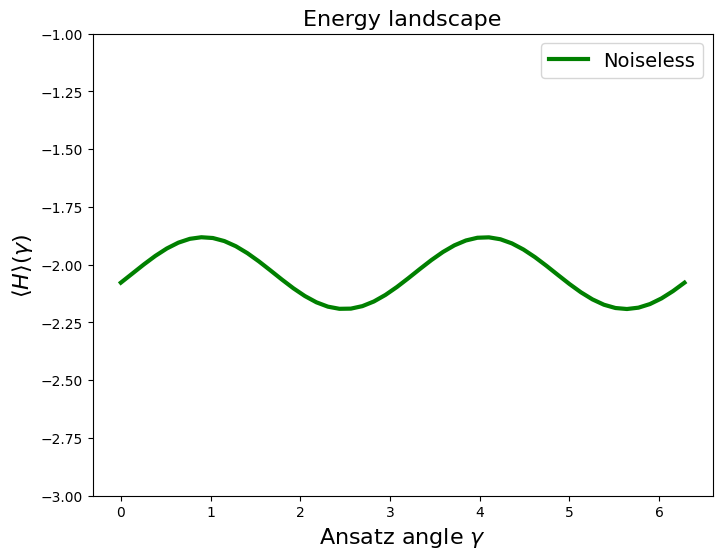

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.title("Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-3, -1);
plt.show()

In [45]:
gammas = np.linspace(0, 2 * np.pi, 50)
expectations = [executor_with_noise(create_ansatz(list_T2,[g])) for g in gammas]
print(expectations)

[-1.9891739789758907, -1.9767296435527348, -1.9642269180483642, -1.9524809458132923, -1.9422573791044173, -1.934222281025705, -1.928898518530275, -1.9266315029587875, -1.927566524361356, -1.9316391684442444, -1.938579449897532, -1.9479293989960136, -1.9590729583695228, -1.9712762412668265, -1.9837355241926606, -1.9956298398809578, -2.006174734373743, -2.014673674318961, -2.0205637426199208, -2.023452632385802, -2.0231445164971262, -2.0196530959743737, -2.0132009673147433, -2.004205342364765, -1.9932510457508914, -1.9810525461413042, -1.9684074943327174, -1.9561447964970111, -1.945070608577731, -1.9359157744053934, -1.9292881366580696, -1.9256328324163037, -1.9252031644686611, -1.9280439497154862, -1.9339884320513594, -1.9426689621500375, -1.9535407484371263, -1.965917130880444, -1.9790140777465726, -1.9920010042393637, -2.0040546002046944, -2.014412158720748, -2.02242093111838, -2.027580294542189, -2.0295739884978965, -2.028290326157735, -2.023829072042198, -2.016494548681168, -2.00677

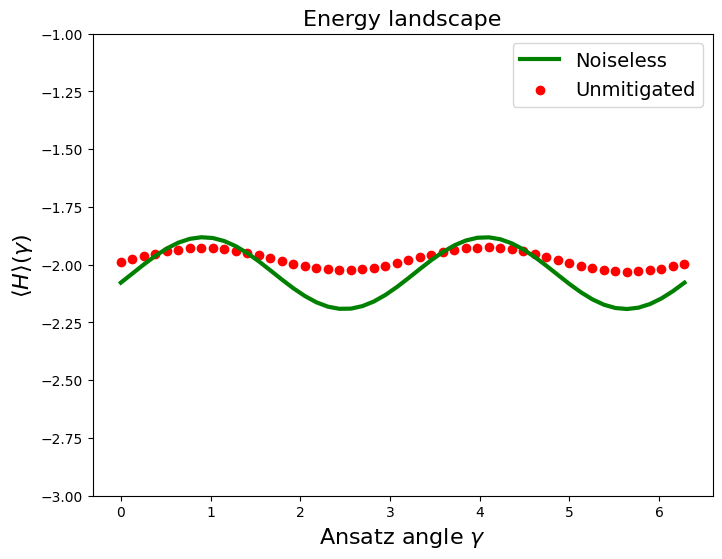

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-3, -1);
plt.show()

In [52]:
type(create_ansatz(list_T2,[0.00]))


qiskit.circuit.quantumcircuit.QuantumCircuit

In [55]:
qc = create_ansatz(list_T2,[phi1])

In [100]:
from mitiq import zne
zne.inference.


In [164]:
fac = LinearFactory(scale_factors=[1, 3, 5])
#fac = PolyFactory(scale_factors=[1, 3, 5,7,9,11,13,15,17], order=8)
#fac = AdaExpFactory(steps=5)
# import fold_gates_from_right from scaling


#zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
scale_noise = zne.scaling.fold_gates_from_right

mitigated_executor = mitigate_executor(executor_with_noise, factory=fac, scale_noise=scale_noise)

In [159]:
from mitiq.zne.scaling import fold_gates_at_random
mitigated_result = zne.execute_with_zne(
     circuit, executor_with_noise, factory=fac, scale_noise=fold_gates_at_random,
)


CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

 Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

     ┌───────────┐                                              »
q_0: ┤ U3(π,0,π) ├──────────────────────────────────────────────»
     ├───────────┤     ┌───┐┌───────────┐                       »
q_1: ┤ U3(π,0,π) ├─────┤ X ├┤ U3(π,0,π) ├───────────────────────»
     └───────────┘┌───┐└─┬─┘├───────────┤                       »
q_2: ─────────────┤ X ├──┼──┤ U3(π,0,π) ├────────────────────■──»
                  └─┬─┘  │  └───────────┘                    │  »
q_3: ───────────────┼────┼───────────────────────────────────┼──»
     ┌───────────┐  │    │                                   │  »
q_4: ┤ U3(π,0,π) ├──┼────┼───────────────────────────────────┼──»
     ├───────────┤  │    │      ┌───┐                        │  »
q_5: ┤ U3(π,0,π) ├──┼────■──────┤ X ├────────────────────────┼──»
     └───────────┘  │           └─┬─┘    ┌────────────────┐┌─┴─┐»
q_6: ───────────────■─────────────■──────┤ U3(phi1/4,0,0) ├┤ X ├»
                                         └────────────────┘└───┘»
q_7: ───────────────────────────────────────────────────────────»
                                                                »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────■───────────────────────────────────────────────»
«                             │                                               »
«q_2: ────────────────────────┼──────────────────────■────────────────────────»
«                             │                      │                        »
«q_3: ────────────────────────┼──────────────────────┼────────────────────────»
«                             │                      │                        »
«q_4: ────────────────────────┼──────────────────────┼────────────────────────»
«                             │                      │                        »
«q_5: ────────────────────────┼──────────────────────┼────────────────────────»
«     ┌────────────────────┐┌─┴─┐┌────────────────┐┌─┴─┐┌────────────────────┐»
«q_6: ┤ U3(-0.25*phi1,0,0) ├┤ X ├┤ U3(phi1/4,0,0) ├┤ X ├┤ U3(-0.25*phi1,0,0) ├»
«     └────────────────────┘└───┘└────────────────┘└───┘└────────────────────┘»
«q_7: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«                                                              ┌───────────┐   »
«q_1: ────────────────────────────────────────────────────■────┤ U3(π,0,π) ├───»
«                                                         │    └───────────┘   »
«q_2: ─────────────────────────■──────────────────────────┼────────────────────»
«                              │                          │                    »
«q_3: ─────────────────────────┼──────────────────────────┼────────────────────»
«                              │                          │                    »
«q_4: ─────────────────────────┼──────────────────────────┼────────────────────»
«                              │                          │                    »
«q_5: ──■──────────────────────┼──────────────────────────┼────────────────────»
«     ┌─┴─┐┌────────────────┐┌─┴─┐┌────────────────────┐┌─┴─┐┌────────────────┐»
«q_6: ┤ X ├┤ U3(phi1/4,0,0) ├┤ X ├┤ U3(-0.25*phi1,0,0) ├┤ X ├┤ U3(phi1/4,0,0) ├»
«     └───┘└────────────────┘└───┘└────────────────────┘└───┘└────────────────┘»
«q_7: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«                                                    
«q_0: ───────────────────────────────────────────────
«                                          ┌───┐     
«q_1: ─────────────────────────────────────┤ X ├─────
«              ┌───────────┐               └─┬─┘┌───┐
«q_2: ──■──────┤ U3(π,0,π) ├─────────────────┼──┤ X ├
«       │      └───────────┘                 │  └─┬─┘
«q_3: ──┼────────────────────────────────────┼────┼──
«       │                                    │    │  
«q_4: ──┼────────────────────────────────────┼────┼──
«       │                             ┌───┐  │    │  
«q_5: ──┼──────────────────────────■──┤ X ├──■────┼──
«     ┌─┴─┐┌────────────────────┐┌─┴─┐└─┬─┘       │  
«q_6: ┤ X ├┤ U3(-0.25*phi1,0,0) ├┤ X ├──■─────────■──
«     └───┘└────────────────────┘└───┘               
«q_7: ───────────────────────────────────────────────
«                                                    

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.

In [73]:
circuit = 

In [74]:
circuit.draw()

┌───────────┐                                              »
q_0: ┤ U3(π,0,π) ├──────────────────────────────────────────────»
     ├───────────┤     ┌───┐┌───────────┐                       »
q_1: ┤ U3(π,0,π) ├─────┤ X ├┤ U3(π,0,π) ├───────────────────────»
     └───────────┘┌───┐└─┬─┘├───────────┤                       »
q_2: ─────────────┤ X ├──┼──┤ U3(π,0,π) ├────────────────────■──»
                  └─┬─┘  │  └───────────┘                    │  »
q_3: ───────────────┼────┼───────────────────────────────────┼──»
     ┌───────────┐  │    │                                   │  »
q_4: ┤ U3(π,0,π) ├──┼────┼───────────────────────────────────┼──»
     ├───────────┤  │    │      ┌───┐                        │  »
q_5: ┤ U3(π,0,π) ├──┼────■──────┤ X ├────────────────────────┼──»
     └───────────┘  │           └─┬─┘    ┌────────────────┐┌─┴─┐»
q_6: ───────────────■─────────────■──────┤ U3(phi1/4,0,0) ├┤ X ├»
                                         └────────────────┘└───┘»
q_7: ───────────────────────────────────────────────────────────»
                                                                »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────■───────────────────────────────────────────────»
«                             │                                               »
«q_2: ────────────────────────┼──────────────────────■────────────────────────»
«                             │                      │                        »
«q_3: ────────────────────────┼──────────────────────┼────────────────────────»
«                             │                      │                        »
«q_4: ────────────────────────┼──────────────────────┼────────────────────────»
«                             │                      │                        »
«q_5: ────────────────────────┼──────────────────────┼────────────────────────»
«     ┌────────────────────┐┌─┴─┐┌────────────────┐┌─┴─┐┌────────────────────┐»
«q_6: ┤ U3(-0.25*phi1,0,0) ├┤ X ├┤ U3(phi1/4,0,0) ├┤ X ├┤ U3(-0.25*phi1,0,0) ├»
«     └────────────────────┘└───┘└────────────────┘└───┘└────────────────────┘»
«q_7: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«                                                              ┌───────────┐   »
«q_1: ────────────────────────────────────────────────────■────┤ U3(π,0,π) ├───»
«                                                         │    └───────────┘   »
«q_2: ─────────────────────────■──────────────────────────┼────────────────────»
«                              │                          │                    »
«q_3: ─────────────────────────┼──────────────────────────┼────────────────────»
«                              │                          │                    »
«q_4: ─────────────────────────┼──────────────────────────┼────────────────────»
«                              │                          │                    »
«q_5: ──■──────────────────────┼──────────────────────────┼────────────────────»
«     ┌─┴─┐┌────────────────┐┌─┴─┐┌────────────────────┐┌─┴─┐┌────────────────┐»
«q_6: ┤ X ├┤ U3(phi1/4,0,0) ├┤ X ├┤ U3(-0.25*phi1,0,0) ├┤ X ├┤ U3(phi1/4,0,0) ├»
«     └───┘└────────────────┘└───┘└────────────────────┘└───┘└────────────────┘»
«q_7: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«                                                    
«q_0: ───────────────────────────────────────────────
«                                     

In [76]:
mitigated_expectations = [mitigated_executor(qiskit.compiler.transpile(create_ansatz(list_T2, [g]), basis_gates=["u1", "u2", "u3", "cx",'cx_o0'])) for g in gammas]

In [78]:
(mitigated_expectations)

[-2.0597078247175435,
 -2.0251488725189053,
 -1.988045679406494,
 -1.95317847799188,
 -1.922827941089258,
 -1.8989793054221298,
 -1.8831925172370931,
 -1.8765001943985813,
 -1.8793400836483005,
 -1.8915264269983374,
 -1.9122621123780523,
 -1.940190813238746,
 -1.9734857050740515,
 -2.0099689601437833,
 -2.0472541991167743,
 -2.0829025835873014,
 -2.1145823433425575,
 -2.1402212968481815,
 -2.1581423926431955,
 -2.167173407234094,
 -2.1667236194351673,
 -2.156822449998154,
 -2.1381175371664245,
 -2.11183237411476,
 -2.0796862810598644,
 -2.0437819425177026,
 -2.0064678710923594,
 -1.970184790058733,
 -1.9373059863781126,
 -1.909982071227164,
 -1.8900003092140398,
 -1.8786677132466199,
 -1.876725551292302,
 -1.8843008608154759,
 -1.900898138600672,
 -1.92543175219642,
 -1.95629695155453,
 -1.9914748349415345,
 -2.0286644076582103,
 -2.0654330899318993,
 -2.0993758314819417,
 -2.1282724286664063,
 -2.1502327473361826,
 -2.1638203566127703,
 -2.1681464875090195,
 -2.1629281665225193,
 -2.1

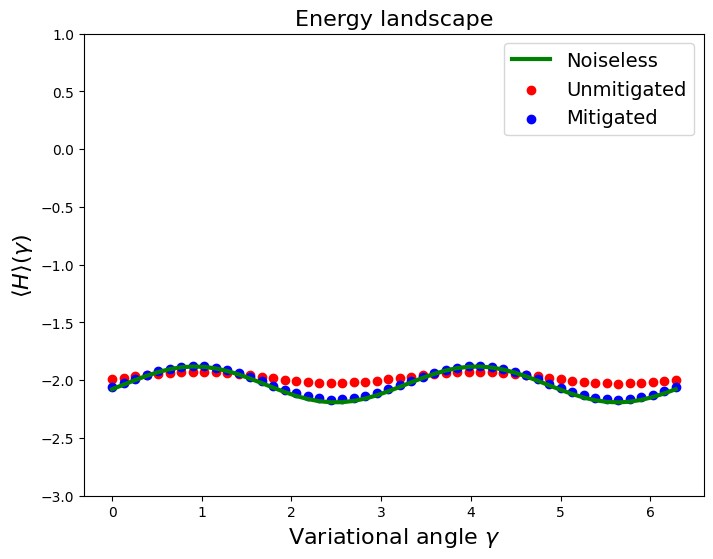

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.scatter(gammas, mitigated_expectations, color="b", label="Mitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Variational angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-3, 1);
plt.show()